In [271]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
# Подавляем предупреждения о несовместимости версий scikit-learn при загрузке энкодеров
warnings.filterwarnings('ignore', message='.*Trying to unpickle.*')
warnings.filterwarnings('ignore', message='.*InconsistentVersionWarning.*')

# Система персональных музыкальных рекомендаций для Яндекс Музыки

Этапы:
1. Загрузка и первичная подготовка данных
2. Исследовательский анализ данных (EDA)  
3. Офлайн-рекомендации (популярные, ALS, похожие треки, ранжирование)
4. Оценка качества
5. Выгрузка в S3

# Инициализация

Сначала загружаем все необходимые пакеты для выполнения кода ноутбука.

In [272]:
# Импорты стандартной библиотеки
import gc
import logging
from datetime import datetime
from pathlib import Path

# Импорты сторонних библиотек
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from catboost import CatBoostRanker, Pool
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import LabelEncoder
from dotenv import load_dotenv

# Настройка логирования для отслеживания этапов
log_file_path = Path('execution_log.txt').absolute()
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - [%(levelname)s] - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[
        logging.FileHandler(log_file_path, mode='w', encoding='utf-8'),
        logging.StreamHandler()
    ],
    force=True  # Переопределяем существующую конфигурацию
)
logger = logging.getLogger(__name__)
# Отключаем буферизацию для немедленной записи
for handler in logger.handlers:
    if isinstance(handler, logging.FileHandler):
        handler.flush()

# Установка констант
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

logger.info("НАЧАЛО ВЫПОЛНЕНИЯ: Система персональных музыкальных рекомендаций")

# Создание необходимых директорий для сохранения результатов (один раз в начале)
Path("recsys/data").mkdir(parents=True, exist_ok=True)
Path("recsys/model").mkdir(parents=True, exist_ok=True)
Path("recsys/recommendations").mkdir(parents=True, exist_ok=True)
Path("recsys/pictures").mkdir(parents=True, exist_ok=True)
logger.info("  ✓ Директории для сохранения результатов подготовлены")

# Константы для выборки данных
USERS_SAMPLE_RATE = 0.25
INTERACTIONS_SAMPLE_RATE = 0.25

# Константы для рекомендаций
TOP_K_RECOMMENDATIONS = 100  # Увеличено с 10 для улучшения метрик
TOP_K_SIMILAR = 6
TOP_POPULAR_COUNT = 100
SIMILAR_ITEMS_LIMIT = 50000
NEGATIVE_SAMPLES_PER_USER = 4
TOP_K_METRICS = 5  # Для расчета Precision@5

# Константы для разделения данных
TRAIN_TEST_SPLIT_DATE = "2022-12-16"
LABEL_SPLIT_DATE = "2022-12-23"

# Дополнительные настройки
sns.set_theme()

2025-11-21 13:40:53 - [INFO] - НАЧАЛО ВЫПОЛНЕНИЯ: Система персональных музыкальных рекомендаций
2025-11-21 13:40:54 - [INFO] -   ✓ Директории для сохранения результатов подготовлены


# ЭТАП 1: Загрузка и первичная подготовка данных

На первом этапе выполняется загрузка исходных данных из файлов формата Parquet и их первичная обработка.

**Цель этапа:** Получить структурированные данные о музыкальных треках, их метаданных и взаимодействиях пользователей, готовые для дальнейшего анализа.

**Входные данные:**
- `tracks.parquet` - информация о музыкальных треках (идентификаторы альбомов, исполнителей, жанров)
- `catalog_names.parquet` - справочник названий треков, альбомов, исполнителей и жанров
- `interactions.parquet` - история взаимодействий пользователей с треками

**Ожидаемый результат:** Очищенные и объединенные данные о треках в формате, удобном для построения рекомендательной системы.

In [273]:
# Загрузка исходных данных из файлов Parquet
# Все три файла содержат критически важную информацию для построения рекомендательной системы
logger.info("ЭТАП 1: Загрузка данных...")
start_time = datetime.now()
tracks = pd.read_parquet("data/tracks.parquet")
logger.info(f"  ✓ Загружено tracks: {len(tracks):,} записей")
catalog_names = pd.read_parquet("data/catalog_names.parquet")
logger.info(f"  ✓ Загружено catalog_names: {len(catalog_names):,} записей")
interactions = pd.read_parquet("data/interactions.parquet")
logger.info(f"  ✓ Загружено interactions: {len(interactions):,} записей")
elapsed = (datetime.now() - start_time).total_seconds()
logger.info(f"  ⏱ Загрузка данных завершена за {elapsed:.2f} сек")

2025-11-21 13:40:54 - [INFO] - ЭТАП 1: Загрузка данных...
2025-11-21 13:40:54 - [INFO] -   ✓ Загружено tracks: 1,000,000 записей
2025-11-21 13:40:55 - [INFO] -   ✓ Загружено catalog_names: 1,812,471 записей
2025-11-21 13:41:50 - [INFO] -   ✓ Загружено interactions: 222,629,898 записей
2025-11-21 13:41:50 - [INFO] -   ⏱ Загрузка данных завершена за 56.63 сек


**Результат загрузки:**
- Данные успешно загружены из трех файлов
- Время загрузки логируется для мониторинга производительности
- Все файлы содержат данные в формате DataFrame, готовые для дальнейшей обработки

### Обзор и валидация данных о треках

Перед началом обработки необходимо проверить качество загруженных данных. 
Особое внимание уделяем проверке уникальности идентификаторов треков, так как дубликаты могут привести к ошибкам при построении рекомендаций.

In [274]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [275]:
# Валидация данных: проверка на дубликаты track_id
duplicated_count = tracks.track_id.duplicated().sum()
if duplicated_count > 0:
    duplicated_ids = tracks[tracks.track_id.duplicated()]['track_id'].unique()[:10]
    error_msg = (
        f"КРИТИЧЕСКАЯ ОШИБКА: Обнаружены {duplicated_count} дубликатов track_id в исходных данных tracks. "
        f"Примеры дублирующихся ID: {duplicated_ids.tolist()}. "
        f"Данные требуют очистки перед дальнейшей обработкой."
    )
    logger.error(error_msg)
    raise ValueError(error_msg)
logger.info("  ✓ Проверка дубликатов track_id: дубликатов не обнаружено")

2025-11-21 13:41:50 - [INFO] -   ✓ Проверка дубликатов track_id: дубликатов не обнаружено


In [276]:
# Просмотр первых строк датафрейма для визуальной проверки структуры данных
# Обратите внимание, что колонки albums, artists, genres содержат списки идентификаторов
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


**Наблюдения:**
- Датафрейм содержит информацию о треках с идентификаторами альбомов, исполнителей и жанров
- Каждая колонка (albums, artists, genres) содержит списки, что усложняет дальнейшую обработку
- Необходимо преобразовать списки в отдельные строки для корректного объединения со справочниками

### Преобразование списков в отдельные строки

Для корректной работы с данными необходимо преобразовать списки идентификаторов в отдельные строки.
Метод `explode` библиотеки pandas позволяет "развернуть" списки, создавая отдельную строку для каждого элемента списка.
Это критически важно для последующего объединения данных со справочниками названий.

In [277]:
logger.info("  → Преобразование tracks (explode списков)...")
start_time = datetime.now()
tracks = tracks \
            .explode(column=["albums"], ignore_index=True) \
            .explode(column=["artists"], ignore_index=True) \
            .explode(column=["genres"], ignore_index=True)
elapsed = (datetime.now() - start_time).total_seconds()
logger.info(f"  ✓ Explode завершен за {elapsed:.2f} сек, записей: {len(tracks):,}")

tracks = tracks.rename(columns={
    "albums": "album_id",
    "artists": "artist_id",
    "genres": "genre_id",
})

# Просмотр результата преобразования
# Теперь каждый трек представлен несколькими строками (по одной для каждой комбинации альбом/исполнитель/жанр)
tracks.head()

2025-11-21 13:41:50 - [INFO] -   → Преобразование tracks (explode списков)...
2025-11-21 13:42:00 - [INFO] -   ✓ Explode завершен за 9.24 сек, записей: 6,765,311


,track_id,album_id,artist_id,genre_id
0,26,3,16,11
1,26,3,16,21
2,26,2490753,16,11
3,26,2490753,16,21
4,38,3,16,11


In [278]:
# Проверка наличия пропущенных значений после преобразования
# Пропущенные значения могут указывать на треки с неизвестными альбомами, исполнителями или жанрами
tracks.isna().sum()

track_id         0
album_id        18
artist_id    41789
genre_id     36675
dtype: int64

**Результат преобразования:**
- Списки идентификаторов успешно развернуты в отдельные строки
- Датафрейм увеличился в размере, так как каждый трек теперь представлен несколькими строками
- Обнаружены пропущенные значения, которые будут обработаны при объединении со справочниками

### Подготовка справочников названий

Датафрейм `catalog_names` содержит все названия треков, альбомов, исполнителей и жанров в едином формате.
Для удобства работы разделим его на отдельные справочники по типам объектов.
Это позволит эффективно объединять данные о треках с их названиями.

In [279]:
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [280]:
genres = catalog_names \
            .query("type == 'genre'") \
            .drop("type", axis=1) \
            .rename(columns={"id": "genre_id", "name": "genre_name"})

track_names = catalog_names \
            .query("type == 'track'") \
            .drop("type", axis=1) \
            .rename(columns={"id": "track_id", "name": "track_name"})

albums = catalog_names \
            .query("type == 'album'") \
            .drop("type", axis=1) \
            .rename(columns={"id": "album_id", "name": "album_name"})

artists = catalog_names \
            .query("type == 'artist'") \
            .drop("type", axis=1) \
            .rename(columns={"id": "artist_id", "name": "artist_name"})

**Результат подготовки справочников:**
- Созданы четыре отдельных справочника: genres, track_names, albums, artists
- Каждый справочник содержит только релевантные данные для своего типа объектов
- Колонки переименованы для удобства последующего объединения

### Объединение данных о треках с метаданными

Теперь объединим данные о треках с названиями из подготовленных справочников.
Это позволит получить полную информацию о каждом треке: его название, исполнителя, альбом и жанр.
Объединение выполняется через left join, чтобы сохранить все треки, даже если для них отсутствуют некоторые метаданные.

In [281]:
logger.info("  → Объединение данных о треках...")
start_time = datetime.now()
track_info = tracks \
            .merge(track_names, on="track_id", how="left") \
            .merge(albums, on="album_id", how="left") \
            .merge(artists, on="artist_id", how="left") \
            .merge(genres, on="genre_id", how="left")
elapsed = (datetime.now() - start_time).total_seconds()
logger.info(f"  ✓ Объединение завершено за {elapsed:.2f} сек")

# Оставляем только необходимые колонки для дальнейшей работы
track_info = track_info[["track_id", "track_name", "artist_name", "album_name", "genre_name"]]

2025-11-21 13:42:02 - [INFO] -   → Объединение данных о треках...
2025-11-21 13:42:15 - [INFO] -   ✓ Объединение завершено за 13.74 сек


**Результат объединения:**
- Все треки объединены с их метаданными (названия, исполнители, альбомы, жанры)
- Датафрейм содержит полную информацию о каждом треке
- После объединения могут появиться дубликаты из-за множественных альбомов/исполнителей/жанров у одного трека

### Удаление дубликатов и оптимизация данных

После объединения данных один трек может быть представлен несколькими строками (из-за множественных альбомов, исполнителей или жанров).
Для построения рекомендательной системы нам нужна одна строка на трек, поэтому оставляем первую запись для каждого уникального track_id.
Также выполняем оптимизацию типов данных для экономии памяти.

In [282]:
# Удаление дубликатов
track_info = track_info.drop_duplicates(subset="track_id", keep="first").reset_index(drop=True)

# Валидация данных: проверка на дубликаты после обработки
duplicated_count = track_info.track_id.duplicated().sum()
if duplicated_count > 0:
    error_msg = (
        f"КРИТИЧЕСКАЯ ОШИБКА: После удаления дубликатов осталось {duplicated_count} дубликатов track_id. "
        f"Это указывает на ошибку в логике обработки данных."
    )
    logger.error(error_msg)
    raise ValueError(error_msg)
logger.info("  ✓ Проверка дубликатов после обработки: дубликатов не обнаружено")

# Оптимизация типов данных для экономии памяти
# int32 достаточно для хранения идентификаторов треков (максимальное значение ~2 млрд)
track_info["track_id"] = track_info["track_id"].astype("int32")

# Освобождение памяти после больших операций
# Удаляем промежуточные данные, которые больше не нужны
del tracks, track_names, albums, artists, genres, catalog_names
gc.collect()

# Просмотр результата обработки
track_info.head()

2025-11-21 13:42:16 - [INFO] -   ✓ Проверка дубликатов после обработки: дубликатов не обнаружено


,track_id,track_name,artist_name,album_name,genre_name
0,26,Complimentary Me,Elizabeth & the Catapult,Taller Children,pop
1,38,Momma's Boy,Elizabeth & the Catapult,Taller Children,pop
2,135,Atticus,Noisettes,Wild Young Hearts,pop
3,136,24 Hours,Noisettes,Wild Young Hearts,pop
4,138,Don't Upset The Rhythm (Go Baby Go),Noisettes,Wild Young Hearts,pop


In [283]:
# Финальная проверка пропущенных значений
# Пропущенные значения могут указывать на треки с неизвестными метаданными
track_info.isna().sum()

track_id           0
track_name         0
artist_name    15369
album_name        18
genre_name      3694
dtype: int64

**Итоги этапа 1:**
- Данные о треках успешно загружены и обработаны
- Списки идентификаторов преобразованы в отдельные строки
- Данные объединены со справочниками названий
- Дубликаты удалены, типы данных оптимизированы
- Датафрейм `track_info` готов для дальнейшего использования

### Анализ данных о взаимодействиях

Теперь рассмотрим данные о взаимодействиях пользователей с музыкальными треками.
Эти данные содержат информацию о том, какие треки прослушивали пользователи и когда это происходило.
Это критически важная информация для построения персональных рекомендаций.

In [284]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [285]:
interactions = interactions.drop("track_seq", axis=1)
interactions['started_at'] = pd.to_datetime(interactions['started_at'])

print("Number of unique users: {:,}".format(interactions.user_id.nunique()))
print("Number of unique tracks: {:,}".format(interactions.track_id.nunique()))

Number of unique users: 1,373,221
Number of unique tracks: 1,000,000


# ЭТАП 2: Исследовательский анализ данных (EDA)

На втором этапе выполняется исследовательский анализ данных для понимания структуры и особенностей датасета.

**Цель этапа:** Получить представление о распределении данных, популярных треках и жанрах, а также подготовить данные для построения рекомендательной системы.

**Задачи:**
- Анализ распределения прослушиваний по времени
- Определение самых популярных треков и жанров
- Выявление треков, которые никто не прослушал
- Подготовка и сохранение данных для этапа 3

**Важно:** Для экономии памяти при EDA используется выборка данных, но для построения рекомендаций будут использоваться все данные выбранных пользователей.

### Создание выборки для EDA

Для выполнения исследовательского анализа создаем случайную выборку из 25% взаимодействий.
Это позволяет эффективно анализировать данные без перегрузки памяти, сохраняя при этом репрезентативность выборки.

In [286]:
logger.info("ЭТАП 2: Исследовательский анализ данных (EDA)...")
logger.info(f"  → Создание выборки ({INTERACTIONS_SAMPLE_RATE*100:.0f}% данных)...")
start_time = datetime.now()
interactions_sample = interactions.sample(frac=INTERACTIONS_SAMPLE_RATE, random_state=RANDOM_STATE)
elapsed = (datetime.now() - start_time).total_seconds()
logger.info(f"  ✓ Выборка создана за {elapsed:.2f} сек")

print("Number of unique users: {:,}".format(interactions_sample.user_id.nunique()))
print("Number of unique tracks: {:,}".format(interactions_sample.track_id.nunique()))
print("Number of interactions: {:,}".format(interactions_sample.shape[0]))

2025-11-21 13:42:25 - [INFO] - ЭТАП 2: Исследовательский анализ данных (EDA)...
2025-11-21 13:42:25 - [INFO] -   → Создание выборки (25% данных)...
2025-11-21 13:42:37 - [INFO] -   ✓ Выборка создана за 11.36 сек


Number of unique users: 1,365,137
Number of unique tracks: 950,986
Number of interactions: 55,657,474


**Результат создания выборки:**
- Создана репрезентативная выборка для EDA
- Выборка сохраняет большую часть информации об уникальных пользователях и треках
- Размер данных значительно уменьшен для эффективного анализа

### Обогащение выборки метаданными

Для более информативного анализа объединяем выборку взаимодействий с метаданными о треках.
Это позволит анализировать не только идентификаторы, но и названия треков, исполнителей и жанры.

In [287]:
interactions_sample = interactions_sample.merge(
    track_info[["track_id", "track_name", "genre_name"]],
    on="track_id",
    how="left",
)

### Анализ распределения прослушиваний по времени

Анализ временного распределения прослушиваний позволяет понять динамику использования сервиса.
Группировка по месяцам показывает сезонные паттерны и общую активность пользователей.
Это важно для понимания контекста данных и может влиять на стратегию рекомендаций.

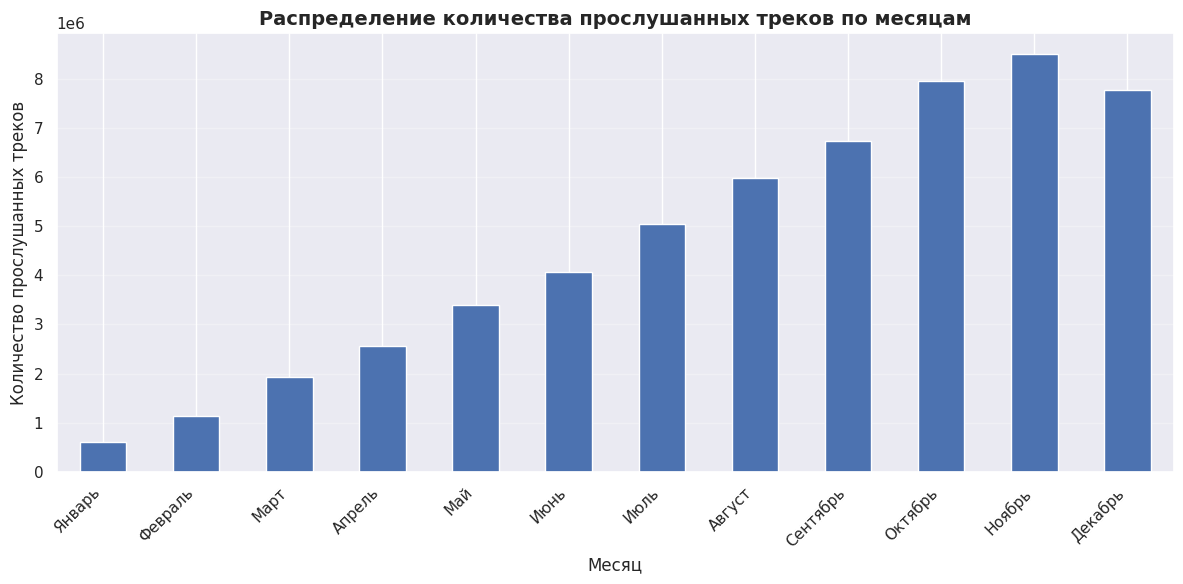

In [288]:
# Создание маппинга месяцев на русские названия
month_names_ru = {
    1: "Январь", 2: "Февраль", 3: "Март", 4: "Апрель",
    5: "Май", 6: "Июнь", 7: "Июль", 8: "Август",
    9: "Сентябрь", 10: "Октябрь", 11: "Ноябрь", 12: "Декабрь"
}

interactions_sample["month"] = interactions_sample["started_at"].dt.month

# Построение графика распределения прослушиваний по месяцам
monthly_counts = interactions_sample.groupby("month")["track_name"].count().sort_index()
ax = monthly_counts.plot(kind="bar", figsize=(12, 6))

plt.xlabel("Месяц", fontsize=12)
plt.ylabel("Количество прослушанных треков", fontsize=12)
plt.title("Распределение количества прослушанных треков по месяцам", fontsize=14, fontweight='bold')
plt.xticks(range(len(monthly_counts)), [month_names_ru[i] for i in monthly_counts.index], rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Сохранение графика
plt.savefig("recsys/pictures/user_activity.png", dpi=150, bbox_inches='tight')
plt.show()

**Результат анализа распределения:**
- Визуализирована динамика прослушиваний по месяцам
- Выявлены периоды повышенной и пониженной активности
- График помогает понять общую картину использования сервиса

### Анализ популярности треков

Определение самых популярных треков важно для понимания музыкальных предпочтений пользователей.
Популярные треки могут использоваться как baseline-рекомендации для новых пользователей (cold start проблема).
Анализ топ-30 треков дает представление о наиболее востребованном контенте.

In [289]:
# Получение данных о популярных треках
top_tracks_data = interactions_sample.track_id \
            .value_counts() \
            .head(30) \
            .reset_index() \
            .merge(
                track_info[["track_id", "track_name", "artist_name"]],
                on="track_id",
                how="left",
            )[["track_id", "track_name", "artist_name", "count"]].set_index("track_id")

# Отображение таблицы
top_tracks_data

,track_name,artist_name,count
track_id,,,
53404,Smells Like Teen Spirit,Nirvana,27596
33311009,Believer,Imagine Dragons,26830
178529,Numb,Linkin Park,25543
35505245,I Got Love,Miyagi & Эндшпиль,24684
65851540,Юность,Dabro,21665
24692821,Way Down We Go,KALEO,21587
32947997,Shape of You,Ed Sheeran,21530
795836,Shape Of My Heart,Sting,21487
51241318,In The End,Tommee Profitt,21457


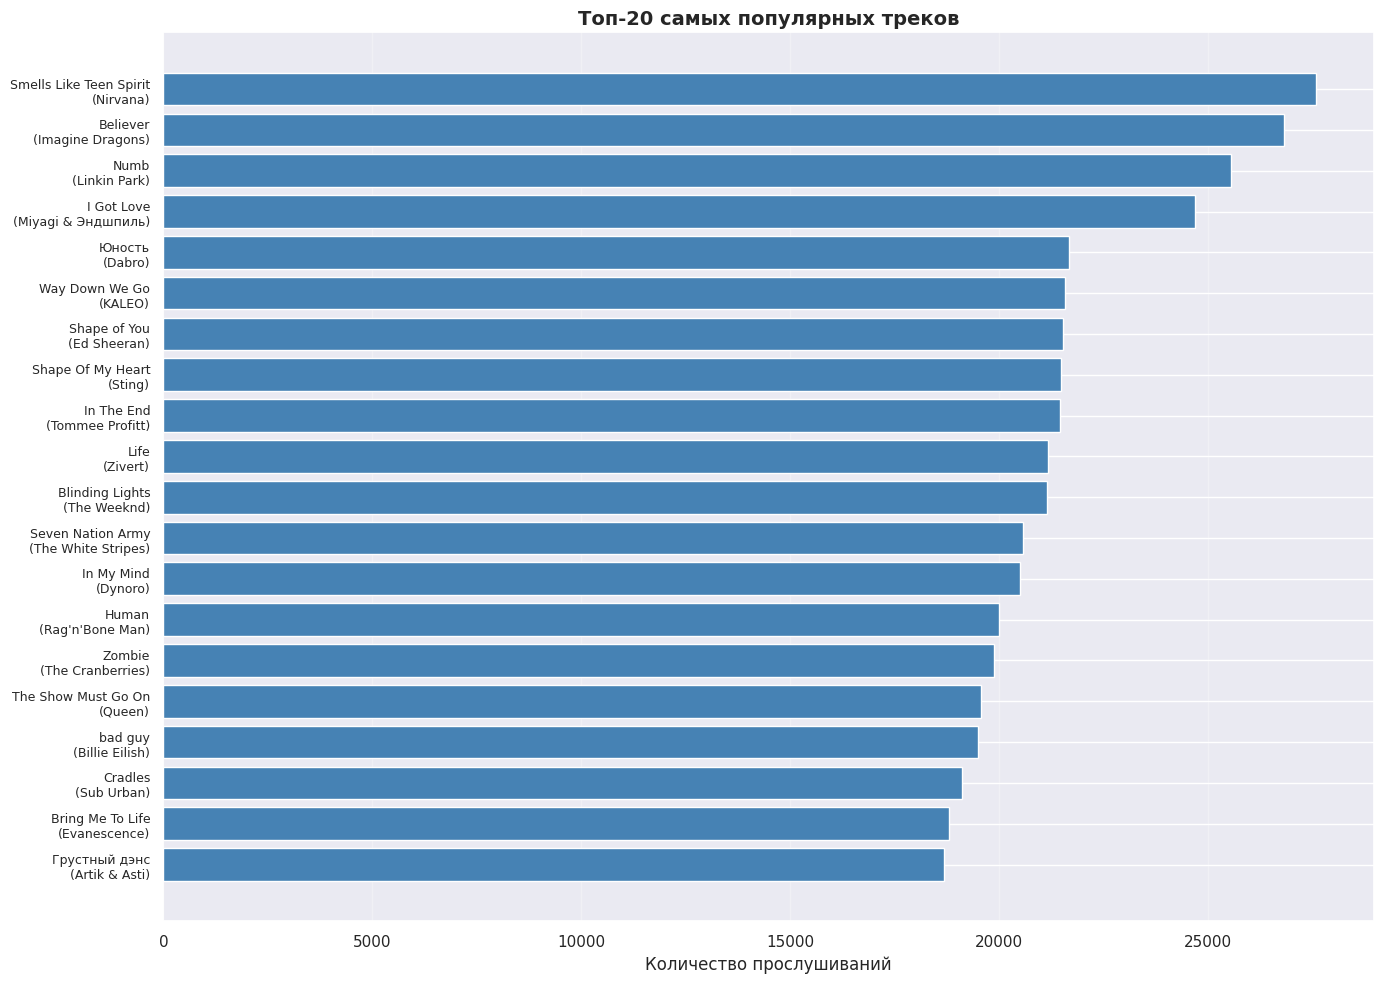

In [290]:
# Построение графика популярных треков
fig, ax = plt.subplots(figsize=(14, 10))
top_tracks_plot = top_tracks_data.head(20).sort_values("count", ascending=True)

# Создаем подписи для треков (название + исполнитель)
track_names = top_tracks_plot['track_name'].fillna('')
artist_names = top_tracks_plot['artist_name'].fillna('')
track_ids = top_tracks_plot.index

# Создание меток
labels = [
    f"{name}\n({artist})" if name and artist else f"Track ID: {tid}"
    for name, artist, tid in zip(track_names, artist_names, track_ids)
]

bars = ax.barh(range(len(top_tracks_plot)), top_tracks_plot["count"], color='steelblue')
ax.set_yticks(range(len(top_tracks_plot)))
ax.set_yticklabels(labels, fontsize=9)
ax.set_xlabel("Количество прослушиваний", fontsize=12)
ax.set_title("Топ-20 самых популярных треков", fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()

# Сохранение графика
plt.savefig("recsys/pictures/top_tracks.png", dpi=150, bbox_inches='tight')
plt.show()

**Результат анализа популярности треков:**
- Определены топ-30 самых популярных треков
- Для каждого трека показано количество прослушиваний
- Информация включает названия треков и исполнителей для интерпретации результатов

### Анализ популярности жанров

Анализ популярности жанров помогает понять музыкальные предпочтения аудитории.
Эта информация может использоваться для улучшения рекомендаций и понимания структуры каталога.
Топ-30 жанров показывает наиболее востребованные музыкальные направления.

In [291]:
# Получение данных о популярных жанрах
top_genres_data = interactions_sample.genre_name.value_counts().head(30)

# Отображение таблицы
top_genres_data

genre_name
pop               13873850
rusrap             6327969
electronics        4672913
dance              3849000
rusrock            3290821
foreignrap         2951954
rock               2588872
alternative        2486226
metal              1600655
indie              1364048
rusestrada         1221573
local-indie        1017882
punk                885731
folk                851817
numetal             559733
shanson             553822
soundtrack          547633
films               524561
hardrock            514213
rnb                 481071
classicmetal        476886
jazz                416389
estrada             356269
epicmetal           316098
classicalmusic      314966
classical           295505
allrock             294781
foreignbard         274326
ukrrock             194016
folkrock            189807
Name: count, dtype: int64

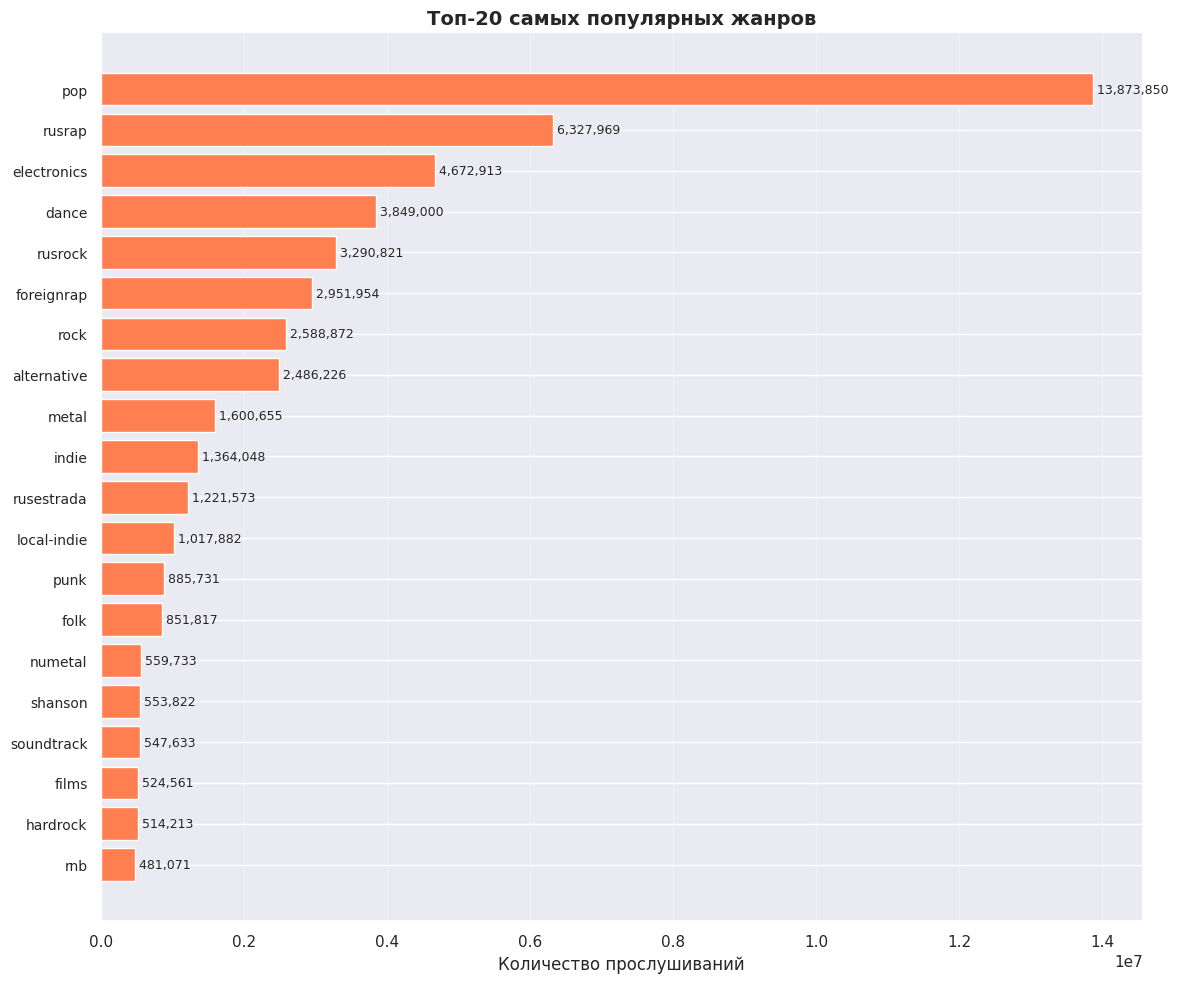

In [292]:
# Построение графика популярных жанров
fig, ax = plt.subplots(figsize=(12, 10))
top_genres_plot = top_genres_data.head(20).sort_values(ascending=True)

bars = ax.barh(range(len(top_genres_plot)), top_genres_plot.values, color='coral')
ax.set_yticks(range(len(top_genres_plot)))
ax.set_yticklabels(top_genres_plot.index, fontsize=10)
ax.set_xlabel("Количество прослушиваний", fontsize=12)
ax.set_title("Топ-20 самых популярных жанров", fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Добавление значений на столбцы
for i, (idx, val) in enumerate(top_genres_plot.items()):
    ax.text(val, i, f' {val:,}', va='center', fontsize=9)

plt.tight_layout()

# Сохранение графика
plt.savefig("recsys/pictures/top_genres.png", dpi=150, bbox_inches='tight')
plt.show()

**Результат анализа жанров:**
- Определены топ-30 самых популярных жанров
- Показано количество прослушиваний для каждого жанра
- Результаты помогают понять структуру музыкальных предпочтений

### Выявление непрослушанных треков

Важно понимать, какая доля каталога остается невостребованной.
Треки, которые никто не прослушал, могут указывать на проблемы с рекомендациями или качеством контента.
В выборке могут быть треки, которые не попали в выборку, но были прослушаны в полном датасете.

In [293]:
# Анализ непрослушанных треков
# Создание множеств для эффективного сравнения
all_tracks = set(track_info.track_id.unique())
listened_tracks = set(interactions_sample.track_id.unique())
unlistened_tracks = all_tracks - listened_tracks

# Проверка корректности: сумма прослушанных и непрослушанных должна равняться общему количеству
assert len(listened_tracks) + len(unlistened_tracks) == len(all_tracks), \
    f"Ошибка проверки корректности данных: сумма прослушанных ({len(listened_tracks):,}) " \
    f"и непрослушанных ({len(unlistened_tracks):,}) треков не равна общему количеству " \
    f"({len(all_tracks):,}). Возможна ошибка в данных или логике вычислений."

# Логирование результатов анализа
unlistened_count = len(unlistened_tracks)
unlistened_share = unlistened_count / len(all_tracks)
logger.info(f"  → Анализ непрослушанных треков:")
logger.info(f"    Непрослушанных треков: {unlistened_count:,} ({unlistened_share:.2%})")

# Освобождение памяти после EDA (interactions_sample больше не нужен)
del interactions_sample, all_tracks, listened_tracks, unlistened_tracks
gc.collect()

2025-11-21 13:43:00 - [INFO] -   → Анализ непрослушанных треков:
2025-11-21 13:43:00 - [INFO] -     Непрослушанных треков: 49,014 (4.90%)


18228

**Итоги EDA:**
- Проанализировано распределение прослушиваний по времени
- Определены самые популярные треки и жанры
- Выявлены треки, не попавшие в выборку
- Получено представление о структуре и особенностях данных

## Преобразование данных для построения рекомендаций

Для построения рекомендательной системы важно работать с полной историей взаимодействий выбранных пользователей.
Поэтому вместо случайной выборки взаимодействий выбираем 25% пользователей и используем все их взаимодействия.
Это позволяет сохранить целостность пользовательских профилей и получить более качественные рекомендации.

In [294]:
logger.info("  → Преобразование данных: выборка пользователей...")
start_time = datetime.now()
# Выборка пользователей
sampled_users = (
    interactions['user_id']
    .drop_duplicates()
    .sample(frac=USERS_SAMPLE_RATE, random_state=RANDOM_STATE)
)
interactions = interactions[interactions['user_id'].isin(sampled_users)].copy()
elapsed = (datetime.now() - start_time).total_seconds()
logger.info(f"  ✓ Выбрано {len(sampled_users):,} пользователей ({USERS_SAMPLE_RATE*100:.0f}%)")
logger.info(f"  ✓ Взаимодействий: {interactions.shape[0]:,} (за {elapsed:.2f} сек)")

# Освобождение памяти
del sampled_users
gc.collect()

2025-11-21 13:43:01 - [INFO] -   → Преобразование данных: выборка пользователей...
2025-11-21 13:43:06 - [INFO] -   ✓ Выбрано 343,305 пользователей (25%)
2025-11-21 13:43:06 - [INFO] -   ✓ Взаимодействий: 55,565,996 (за 4.46 сек)


0

**Результат выборки пользователей:**
- Выбрано 25% пользователей для построения рекомендаций
- Сохранена полная история взаимодействий выбранных пользователей
- Размер данных оптимизирован для эффективной работы алгоритмов

### Кодирование идентификаторов

Для эффективной работы алгоритмов машинного обучения необходимо преобразовать идентификаторы пользователей и треков в последовательные числовые индексы.
LabelEncoder из scikit-learn выполняет это преобразование, создавая маппинг между исходными ID и новыми индексами.
Это критически важно для работы с разреженными матрицами и алгоритмами коллаборативной фильтрации.

In [295]:
logger.info("  → Кодирование идентификаторов...")
start_time = datetime.now()
user_id_encoder = LabelEncoder()
track_id_encoder = LabelEncoder()

user_id_encoder.fit(interactions["user_id"])
track_id_encoder.fit(interactions["track_id"])

interactions["user_id_encoded"] = user_id_encoder.transform(interactions["user_id"])
interactions["track_id_encoded"] = track_id_encoder.transform(interactions["track_id"])
elapsed = (datetime.now() - start_time).total_seconds()
logger.info(f"  ✓ Кодирование завершено за {elapsed:.2f} сек")
logger.info(f"    Уникальных пользователей: {len(user_id_encoder.classes_):,}")
logger.info(f"    Уникальных треков: {len(track_id_encoder.classes_):,}")

2025-11-21 13:43:06 - [INFO] -   → Кодирование идентификаторов...
2025-11-21 13:43:19 - [INFO] -   ✓ Кодирование завершено за 13.67 сек
2025-11-21 13:43:19 - [INFO] -     Уникальных пользователей: 343,305
2025-11-21 13:43:19 - [INFO] -     Уникальных треков: 950,398


**Результат кодирования:**
- Все идентификаторы пользователей и треков преобразованы в последовательные числовые индексы
- Созданы энкодеры для обратного преобразования при необходимости
- Данные готовы для построения разреженных матриц взаимодействий

### Сохранение подготовленных данных

Сохраняем обработанные данные и обученные энкодеры для использования на следующих этапах.
Это позволяет не повторять обработку данных при повторных запусках и обеспечивает воспроизводимость результатов.
Данные сохраняются в формате Parquet для эффективного хранения и быстрой загрузки.

In [296]:
# Проверка наличия уже сохраненных данных
items_path = Path("recsys/data/items.parquet")
events_path = Path("recsys/data/events.parquet")
user_encoder_path = Path("recsys/model/user_encoder.pkl")
item_encoder_path = Path("recsys/model/item_encoder.pkl")

if items_path.exists() and events_path.exists() and user_encoder_path.exists() and item_encoder_path.exists():
    logger.info("  → Обнаружены сохраненные данные, загружаем с диска...")
    track_info = pd.read_parquet(items_path)
    interactions = pd.read_parquet(events_path)
    user_id_encoder = joblib.load(user_encoder_path)
    track_id_encoder = joblib.load(item_encoder_path)
    logger.info("  ✓ Данные загружены с диска")
else:
    logger.info("  → Сохранение подготовленных данных...")
    track_info.to_parquet(items_path)
    interactions.to_parquet(events_path)
    joblib.dump(user_id_encoder, user_encoder_path)
    joblib.dump(track_id_encoder, item_encoder_path)
    logger.info("  ✓ Данные сохранены")

2025-11-21 13:43:19 - [INFO] -   → Обнаружены сохраненные данные, загружаем с диска...
2025-11-21 13:43:23 - [INFO] -   ✓ Данные загружены с диска


**Итоги этапа 2:**
- Выполнен исследовательский анализ данных
- Данные подготовлены для построения рекомендаций
- Идентификаторы закодированы для эффективной работы алгоритмов
- Данные и энкодеры сохранены для последующих этапов

# ЭТАП 3: Построение офлайн-рекомендаций

На третьем этапе строится система рекомендаций с использованием различных подходов.

**Цель этапа:** Создать несколько типов рекомендаций и объединить их в финальный ранжированный список.

**Типы рекомендаций:**
1. **Топ популярных** - самые популярные треки (baseline для новых пользователей)
2. **Персональные ALS** - рекомендации на основе коллаборативной фильтрации (Alternating Least Squares)
3. **Похожие треки (i2i)** - рекомендации на основе схожести треков
4. **Финальные ранжированные** - комбинация всех подходов с использованием модели ранжирования CatBoost

**Методология:**
- Разделение данных на обучающую и тестовую выборки
- Обучение модели ALS для коллаборативной фильтрации
- Построение признаков для модели ранжирования
- Обучение CatBoost для финального ранжирования рекомендаций

### Разделение данных на обучающую и тестовую выборки

Для корректной оценки качества рекомендаций необходимо разделить данные на обучающую и тестовую выборки.
Используется временное разделение: все взаимодействия до 16 декабря 2022 года относятся к обучающей выборке,
а взаимодействия после этой даты - к тестовой. Такой подход имитирует реальную ситуацию, когда рекомендации
строятся на основе прошлых данных и оцениваются на будущих взаимодействиях.

In [297]:
logger.info("ЭТАП 3: Офлайн-рекомендации...")
logger.info("  → Разделение данных на train/test...")
start_time = datetime.now()
train_test_split_date = pd.to_datetime(TRAIN_TEST_SPLIT_DATE)

train_test_split_idx = interactions["started_at"] < train_test_split_date
train_data = interactions[train_test_split_idx].copy()
test_data = interactions[~train_test_split_idx].copy()

elapsed = (datetime.now() - start_time).total_seconds()
logger.info(f"  ✓ Разделение завершено за {elapsed:.2f} сек")
logger.info(f"    Train: {train_data.shape[0]:,} взаимодействий")
logger.info(f"    Test: {test_data.shape[0]:,} взаимодействий")

2025-11-21 13:43:23 - [INFO] - ЭТАП 3: Офлайн-рекомендации...
2025-11-21 13:43:23 - [INFO] -   → Разделение данных на train/test...
2025-11-21 13:43:25 - [INFO] -   ✓ Разделение завершено за 2.33 сек
2025-11-21 13:43:25 - [INFO] -     Train: 52,081,996 взаимодействий
2025-11-21 13:43:25 - [INFO] -     Test: 3,484,000 взаимодействий


Вычислим рейтинг популярности треков на основе нормализованного количества прослушиваний:

In [298]:
track_popularity = train_data.groupby("track_id_encoded")["user_id_encoded"].count()
track_popularity /= track_popularity.max()
track_popularity = track_popularity.reset_index()
track_popularity = track_popularity.rename(columns={"user_id_encoded": "tracks_played"})

train_data = train_data.merge(track_popularity, on="track_id_encoded", how="left")

**Результат разделения данных:**
- Данные разделены на обучающую и тестовую выборки по временной метке
- Вычислен рейтинг популярности треков на основе нормализованного количества прослушиваний
- Рейтинг добавлен к обучающим данным для использования в алгоритмах

### Построение рекомендаций: Топ популярных треков

Самый простой тип рекомендаций - это топ самых популярных треков.
Такие рекомендации используются как baseline и особенно эффективны для новых пользователей (cold start проблема).
Выбираем топ-100 самых популярных треков на основе количества прослушиваний в обучающей выборке.

In [299]:
# Проверка наличия топ популярных треков
top_popular_path = Path("recsys/recommendations/top_popular.parquet")

if top_popular_path.exists():
    logger.info("  → Обнаружены сохраненные топ популярные треки, загружаем с диска...")
    top_popular = pd.read_parquet(top_popular_path)
    # Добавляем track_id_encoded для дальнейших расчетов
    top_popular["track_id_encoded"] = track_id_encoder.transform(top_popular["track_id"])
    # Если tracks_played отсутствует, создаем его из rank (обратный порядок)
    if "tracks_played" not in top_popular.columns:
        top_popular["tracks_played"] = 1.0 / top_popular["rank"]
    logger.info("  ✓ Топ популярные треки загружены с диска")
else:
    logger.info("  → Расчет топ популярных треков...")
    top_popular = train_data.track_id \
                .value_counts() \
                .head(TOP_POPULAR_COUNT) \
                .reset_index() \
                .rename(columns={"count": "tracks_played"}) \
                .merge(
                    track_info[["track_id", "track_name", "artist_name"]],
                    on="track_id",
                    how="left",
                )[["track_id", "track_name", "artist_name", "tracks_played"]]

    top_popular["track_id_encoded"] = track_id_encoder.transform(top_popular["track_id"])
    top_popular["rank"] = range(1, len(top_popular) + 1)
    logger.info("  ✓ Топ популярные треки рассчитаны")

2025-11-21 13:43:33 - [INFO] -   → Обнаружены сохраненные топ популярные треки, загружаем с диска...
2025-11-21 13:43:33 - [INFO] -   ✓ Топ популярные треки загружены с диска


### Персональные рекомендации (ALS)

Создадим разреженную матрицу пользователь-трек:

In [300]:
logger.info("  → Создание sparse матрицы пользователь-трек...")
start_time = datetime.now()
# Создание sparse матрицы
user_item_matrix_train = scipy.sparse.coo_matrix(
    (
        train_data["tracks_played"].values.astype(np.float32),
        (train_data["user_id_encoded"].values, train_data["track_id_encoded"].values)
    ),
    shape=(len(user_id_encoder.classes_), len(track_id_encoder.classes_)),
    dtype=np.float32
).tocsr()  # Конвертируем в CSR для эффективных операций ALS
elapsed = (datetime.now() - start_time).total_seconds()
logger.info(f"  ✓ Sparse матрица создана за {elapsed:.2f} сек")
logger.info(f"    Размер: {user_item_matrix_train.shape}, заполненность: {user_item_matrix_train.nnz / np.prod(user_item_matrix_train.shape) * 100:.4f}%")

2025-11-21 13:43:33 - [INFO] -   → Создание sparse матрицы пользователь-трек...
2025-11-21 13:43:33 - [INFO] -   ✓ Sparse матрица создана за 0.87 сек
2025-11-21 13:43:33 - [INFO] -     Размер: (343305, 950398), заполненность: 0.0160%


Обучим модель ALS:

In [301]:
# Проверка наличия уже обученной модели ALS
als_model_path = Path("recsys/model/als_model.pkl")

if als_model_path.exists():
    logger.info("  → Обнаружена сохраненная модель ALS, загружаем с диска...")
    als_model = joblib.load(als_model_path)
    logger.info("  ✓ Модель ALS загружена с диска")
else:
    logger.info("  → Обучение модели ALS...")
    start_time = datetime.now()
    als_params = {
        "factors": 50,
        "iterations": 100,
        "regularization": 0.05,
        "random_state": RANDOM_STATE,
        "num_threads": 4,  # Используем все 4 ядра CPU для ускорения обучения
    }

    als_model = AlternatingLeastSquares(**als_params)
    als_model.fit(user_item_matrix_train)
    elapsed = (datetime.now() - start_time).total_seconds()
    logger.info(f"  ✓ Модель ALS обучена за {elapsed:.2f} сек")

    # Сохраним ALS модель
    joblib.dump(als_model, als_model_path)
    logger.info("  ✓ Модель ALS сохранена")

2025-11-21 13:43:33 - [INFO] -   → Обнаружена сохраненная модель ALS, загружаем с диска...
2025-11-21 13:43:37 - [INFO] -   ✓ Модель ALS загружена с диска


Генерируем персональные рекомендации (top-10 для каждого пользователя):

In [302]:
# Проверка наличия персональных рекомендаций
personal_als_path = Path("recsys/recommendations/personal_als.parquet")

if personal_als_path.exists():
    logger.info("  → Обнаружены сохраненные персональные рекомендации, загружаем с диска...")
    personal_recs = pd.read_parquet(personal_als_path)
    # Если нет score, создаем из rank (для совместимости со старыми файлами)
    if "score" not in personal_recs.columns and "rank" in personal_recs.columns:
        personal_recs["score"] = 1.0 / personal_recs["rank"]
    personal_recs = personal_recs[["user_id", "track_id", "score"]].copy()
    logger.info("  ✓ Персональные рекомендации загружены с диска")
else:
    logger.info("  → Генерация персональных рекомендаций (ALS)...")
    start_time = datetime.now()
    user_ids_encoded = range(len(user_id_encoder.classes_))

    als_recommendations = als_model.recommend(
        user_ids_encoded, 
        user_item_matrix_train[user_ids_encoded], 
        filter_already_liked_items=False, 
        N=TOP_K_RECOMMENDATIONS,
    )
    elapsed = (datetime.now() - start_time).total_seconds()
    logger.info(f"  ✓ Рекомендации сгенерированы за {elapsed:.2f} сек")

    # Преобразуем результаты в DataFrame
    track_ids_encoded = als_recommendations[0]
    als_scores = als_recommendations[1]

    # Создание DataFrame
    user_ids_repeated = np.repeat(user_ids_encoded, TOP_K_RECOMMENDATIONS)
    personal_recs = pd.DataFrame({
        "user_id_encoded": user_ids_repeated,
        "track_id_encoded": track_ids_encoded.ravel(),
        "score": als_scores.ravel().astype(np.float32),
    })

    personal_recs["user_id"] = user_id_encoder.inverse_transform(personal_recs["user_id_encoded"])
    personal_recs["track_id"] = track_id_encoder.inverse_transform(personal_recs["track_id_encoded"])
    personal_recs = personal_recs.drop(columns=["user_id_encoded", "track_id_encoded"])

    personal_recs = personal_recs[["user_id", "track_id", "score"]]
    logger.info("  ✓ Персональные рекомендации рассчитаны")

2025-11-21 13:43:37 - [INFO] -   → Обнаружены сохраненные персональные рекомендации, загружаем с диска...
2025-11-21 13:43:38 - [INFO] -   ✓ Персональные рекомендации загружены с диска


### Похожие треки (item-to-item)

Вычислим похожие треки для части треков (для экономии времени):

In [303]:
# Проверка наличия похожих треков
similar_path = Path("recsys/recommendations/similar.parquet")

if similar_path.exists():
    logger.info("  → Обнаружены сохраненные похожие треки, загружаем с диска...")
    similar_tracks = pd.read_parquet(similar_path)
    logger.info("  ✓ Похожие треки загружены с диска")
else:
    logger.info("  → Поиск похожих треков (item-to-item)...")
    start_time = datetime.now()
    train_track_ids_encoded = range(len(track_id_encoder.classes_))[:SIMILAR_ITEMS_LIMIT]

    similar_items = als_model.similar_items(train_track_ids_encoded, N=TOP_K_SIMILAR)
    elapsed = (datetime.now() - start_time).total_seconds()
    logger.info(f"  ✓ Похожие треки найдены за {elapsed:.2f} сек (для {SIMILAR_ITEMS_LIMIT:,} треков)")

    # Преобразуем результаты в DataFrame
    sim_item_item_ids_enc = similar_items[0]
    sim_item_scores = similar_items[1]

    # Создание DataFrame
    track_ids_repeated = np.repeat(train_track_ids_encoded, TOP_K_SIMILAR)
    similar_tracks = pd.DataFrame({
        "track_id_encoded": track_ids_repeated,
        "sim_track_id_encoded": sim_item_item_ids_enc.ravel().astype(np.int64),
        "score": sim_item_scores.ravel().astype(np.float32)
    })

    similar_tracks["track_id_1"] = track_id_encoder.inverse_transform(similar_tracks["track_id_encoded"])
    similar_tracks["track_id_2"] = track_id_encoder.inverse_transform(similar_tracks["sim_track_id_encoded"])
    similar_tracks = similar_tracks.drop(columns=["track_id_encoded", "sim_track_id_encoded"])

    # Фильтрация треков, похожих на самих себя
    similar_tracks = similar_tracks.query("track_id_1 != track_id_2")
    similar_tracks = similar_tracks[["track_id_1", "track_id_2", "score"]]
    logger.info("  ✓ Похожие треки рассчитаны")
    
    # Сохраняем сразу после расчета
    similar_tracks.to_parquet(similar_path)
    logger.info("  ✓ Похожие треки сохранены")

2025-11-21 13:43:38 - [INFO] -   → Обнаружены сохраненные похожие треки, загружаем с диска...
2025-11-21 13:43:38 - [INFO] -   ✓ Похожие треки загружены с диска


### Инженерия признаков и ранжирование

Создадим признаки для ранжирования рекомендаций:

In [304]:
# Добавление жанра к рекомендациям
candidates_for_train = personal_recs.merge(
    track_info[["track_id", "genre_name"]],
    on="track_id",
    how="left"
)

# Доля жанра в обучающих взаимодействиях
genre_shares = train_data \
                .merge(track_info[["track_id", "genre_name"]], on="track_id", how="left") \
                .groupby("genre_name")["track_id"].count()
genre_shares /= genre_shares.sum()
genre_shares = genre_shares.reset_index().rename(columns={"track_id": "genre_share", "genre_name": "genre_name"})

candidates_for_train = candidates_for_train.merge(
    genre_shares,
    left_on="genre_name",
    right_on="genre_name",
    how="left"
)

candidates_for_train = candidates_for_train.rename(columns={"score": "als_score"})

Создадим метки для обучения ранжировщика:

In [305]:
# Разделение тестовых данных для меток
split_date_for_labels = pd.to_datetime(LABEL_SPLIT_DATE)
split_date_for_labels_idx = test_data["started_at"] < split_date_for_labels
events_labels = test_data[split_date_for_labels_idx].copy()
events_test_2 = test_data[~split_date_for_labels_idx].copy()

# Создание меток
events_labels["target"] = 1
candidates = candidates_for_train.merge(
    events_labels[["user_id", "track_id", "target"]],
    on=["user_id", "track_id"],
    how="left",
)
candidates["target"] = candidates["target"].fillna(0).astype("int")

# Балансировка классов
users_with_positive = candidates.groupby("user_id")["target"].sum() > 0
users_with_positive = users_with_positive[users_with_positive].index
candidates = candidates[candidates["user_id"].isin(users_with_positive)]

# Балансировка: перемешиваем и берем первые N
positive = candidates.query("target == 1")
negative = candidates.query("target == 0")

# Перемешиваем негативные примеры векторно
shuffled_negatives = negative.sample(frac=1, random_state=RANDOM_STATE)
# Группируем и берем первые N (быстрее чем apply)
negatives_sample = shuffled_negatives.groupby("user_id", group_keys=False).head(NEGATIVE_SAMPLES_PER_USER)

candidates_for_train = pd.concat([positive, negatives_sample], ignore_index=True)

# Освобождение памяти после балансировки
del candidates
gc.collect()

6

**Результат подготовки данных для обучения:**
- Созданы метки для обучения модели ранжирования
- Выполнена балансировка классов для корректного обучения
- Данные готовы для обучения модели CatBoost

### Обучение модели ранжирования CatBoost

Для финального ранжирования рекомендаций используется модель градиентного бустинга CatBoostRanker.
Модель обучается на трех признаках: ALS-оценка, жанр трека и доля жанра в обучающих данных.
CatBoostRanker специально разработан для задач ранжирования и использует функцию потерь YetiRank,
что делает его идеальным выбором для задачи ранжирования рекомендаций.

In [306]:
# Определение признаков для модели ранжирования
# als_score - оценка релевантности от модели ALS
# genre_name - жанр трека (категориальный признак)
# genre_share - доля жанра в обучающих взаимодействиях
features = ["als_score", "genre_name", "genre_share"]
cat_features = ["genre_name"]
target = ["target"]

# Проверка наличия уже обученной модели CatBoost
catboost_model_path = Path("recsys/model/catboost_ranker.pkl")

if catboost_model_path.exists():
    logger.info("  → Обнаружена сохраненная модель CatBoost, загружаем с диска...")
    model = joblib.load(catboost_model_path)
    logger.info("  ✓ Модель CatBoost загружена с диска")
else:
    logger.info("  → Обучение модели ранжирования CatBoost...")
    start_time = datetime.now()
    
    # КРИТИЧНО: Для CatBoostRanker данные должны быть отсортированы по group_id
    # Все записи одного пользователя должны идти подряд
    candidates_for_train_sorted = candidates_for_train.sort_values("user_id").reset_index(drop=True)
    
    train_data_pool = Pool(
        data=candidates_for_train_sorted[features],
        label=candidates_for_train_sorted[target],
        group_id=candidates_for_train_sorted["user_id"],  # Группировка по пользователям для Ranker
        cat_features=cat_features,
    )

    catboost_params = {
        "iterations": 1000,  # Уменьшено для Ranker (более эффективен)
        "learning_rate": 0.03,  # Уменьшен learning rate для лучшей стабильности
        "depth": 4,  # Немного увеличена глубина
        "verbose": 100,
        "loss_function": "YetiRank",  # Специально для ранжирования
        "random_seed": RANDOM_STATE,
    }

    model = CatBoostRanker(**catboost_params)
    model.fit(train_data_pool)
    elapsed = (datetime.now() - start_time).total_seconds()
    logger.info(f"  ✓ Модель CatBoost обучена за {elapsed:.2f} сек")

    # Сохраним модель ранжирования
    joblib.dump(model, catboost_model_path)
    logger.info("  ✓ Модель CatBoost сохранена")

2025-11-21 13:43:50 - [INFO] -   → Обнаружена сохраненная модель CatBoost, загружаем с диска...
2025-11-21 13:43:50 - [INFO] -   ✓ Модель CatBoost загружена с диска


**Результат обучения модели ранжирования:**
- Модель CatBoost успешно обучена на подготовленных данных
- Модель сохранена для возможного повторного использования
- Модель готова к применению для ранжирования рекомендаций

### Генерация финальных рекомендаций для тестовых данных

Для оценки качества рекомендаций необходимо сгенерировать рекомендации для тестовых данных.
Для этого объединяем обучающие данные с данными для меток (events_labels), чтобы учесть
дополнительную информацию о взаимодействиях пользователей. Затем генерируем рекомендации
с использованием уже обученной модели ALS (без переобучения) и применяем модель ранжирования.

In [307]:
# Объединение train и labels для инференса
# Это позволяет учесть дополнительную информацию о взаимодействиях при генерации рекомендаций
logger.info("  → Подготовка данных для инференса...")
start_time = datetime.now()
inference_data = pd.concat([train_data, events_labels], ignore_index=True)

# Освобождение памяти после создания inference_data
del events_labels
gc.collect()

# Создание sparse матрицы для инференса
user_item_matrix_inference = scipy.sparse.coo_matrix(
    (
        inference_data["tracks_played"].values.astype(np.float32),
        (inference_data["user_id_encoded"].values, inference_data["track_id_encoded"].values)
    ),
    shape=(len(user_id_encoder.classes_), len(track_id_encoder.classes_)),
    dtype=np.float32
).tocsr()

# Определяем user_ids_encoded для инференса (если не был определен ранее)
if 'user_ids_encoded' not in locals():
    user_ids_encoded = range(len(user_id_encoder.classes_))

# Используем уже обученную модель с recalculate_user=True
logger.info("  → Генерация рекомендаций с пересчетом пользователей (без переобучения)...")
als_recommendations_inference = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_inference[user_ids_encoded], 
    filter_already_liked_items=False,
    recalculate_user=True,  # Пересчитывает векторы пользователей на основе новой матрицы
    N=TOP_K_RECOMMENDATIONS,
)
elapsed = (datetime.now() - start_time).total_seconds()
logger.info(f"  ✓ Рекомендации для инференса сгенерированы за {elapsed:.2f} сек (без переобучения модели)")

# Освобождение памяти после использования матрицы
del user_item_matrix_inference
gc.collect()

track_ids_encoded = als_recommendations_inference[0]
als_scores = als_recommendations_inference[1]

# Создание DataFrame
user_ids_repeated = np.repeat(user_ids_encoded, TOP_K_RECOMMENDATIONS)
als_recommendations_inference = pd.DataFrame({
    "user_id_encoded": user_ids_repeated,
    "track_id_encoded": track_ids_encoded.ravel(),
    "score": als_scores.ravel().astype(np.float32),
})

als_recommendations_inference["user_id"] = user_id_encoder.inverse_transform(
    als_recommendations_inference["user_id_encoded"]
)
als_recommendations_inference["track_id"] = track_id_encoder.inverse_transform(
    als_recommendations_inference["track_id_encoded"]
)
als_recommendations_inference = als_recommendations_inference.drop(
    columns=["user_id_encoded", "track_id_encoded"]
)

als_recommendations_inference = als_recommendations_inference[["user_id", "track_id", "score"]]

# Добавление признаков
test_user_ids = set(events_test_2.user_id.unique())
candidates_to_rank = als_recommendations_inference[
    als_recommendations_inference.user_id.isin(test_user_ids)
]

# Объединенный merge: сначала добавляем genre_name, затем genre_share
# Подготовим объединенный DataFrame для одного merge
track_info_with_genre_share = track_info[["track_id", "genre_name"]].merge(
    genre_shares,
    on="genre_name",
    how="left"
)

candidates_to_rank = candidates_to_rank.merge(
    track_info_with_genre_share,
    on="track_id",
    how="left"
)

candidates_to_rank = candidates_to_rank.rename(columns={"score": "als_score"})

# Предсказание и ранжирование
# КРИТИЧНО: Сортируем по user_id для группировки (требуется для Ranker)
candidates_to_rank = candidates_to_rank.sort_values("user_id").reset_index(drop=True)

# КРИТИЧНО: Заполняем пропущенные значения перед инференсом
# CatBoostRanker не может обработать None значения
candidates_to_rank_for_pred = candidates_to_rank[features].copy()
candidates_to_rank_for_pred = candidates_to_rank_for_pred.fillna({
    "als_score": 0.0,  # Если нет ALS оценки, используем 0
    "genre_name": "unknown",  # Если нет жанра, используем "unknown"
    "genre_share": 0.0  # Если нет доли жанра, используем 0
})

inf_data = Pool(
    data=candidates_to_rank_for_pred,
    cat_features=cat_features,
    group_id=candidates_to_rank["user_id"]  
)
predictions = model.predict(inf_data)  
candidates_to_rank["score"] = predictions

candidates_to_rank = candidates_to_rank.sort_values(
    by=["user_id", "score"], ascending=[True, False]
)
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

final_recommendations = candidates_to_rank[["user_id", "track_id", "score", "rank"]]

# Освобождение памяти после создания финальных рекомендаций (но candidates_to_rank еще нужен для метрик)
del als_recommendations_inference
gc.collect()

2025-11-21 13:43:50 - [INFO] -   → Подготовка данных для инференса...


2025-11-21 13:43:52 - [INFO] -   → Генерация рекомендаций с пересчетом пользователей (без переобучения)...
2025-11-21 13:53:57 - [INFO] -   ✓ Рекомендации для инференса сгенерированы за 607.61 сек (без переобучения модели)


0

Сохраним рекомендации:

In [308]:
# Проверка наличия уже сохраненных рекомендаций
top_popular_path = Path("recsys/recommendations/top_popular.parquet")
personal_als_path = Path("recsys/recommendations/personal_als.parquet")
similar_path = Path("recsys/recommendations/similar.parquet")
recommendations_path = Path("recsys/recommendations/recommendations.parquet")

if (top_popular_path.exists() and personal_als_path.exists() and 
    similar_path.exists() and recommendations_path.exists()):
    logger.info("  → Обнаружены сохраненные рекомендации, загружаем с диска...")
    # top_popular и personal_recs уже загружены выше
    similar_tracks = pd.read_parquet(similar_path)
    final_recommendations = pd.read_parquet(recommendations_path)
    # Если нет score, создаем из rank (для совместимости со старыми файлами)
    if "score" not in final_recommendations.columns and "rank" in final_recommendations.columns:
        final_recommendations["score"] = 1.0 / final_recommendations["rank"]
    logger.info("  ✓ Рекомендации загружены с диска")
else:
    logger.info("  → Сохранение рекомендаций...")
    # Сохраняем top_popular с track_id, rank и tracks_played (для метрик)
    # Проверяем наличие колонки rank, если нет - создаем
    if "rank" not in top_popular.columns:
        top_popular["rank"] = range(1, len(top_popular) + 1)
    # Сохраняем tracks_played для расчета метрик recall_gen
    columns_to_save = ["track_id", "rank"]
    if "tracks_played" in top_popular.columns:
        columns_to_save.append("tracks_played")
    top_popular[columns_to_save].to_parquet(top_popular_path)
    
    # Сохраняем personal_als с track_id, score и rank
    personal_recs_to_save = personal_recs[["user_id", "track_id", "score"]].copy()
    if "rank" not in personal_recs_to_save.columns:
        personal_recs_to_save["rank"] = personal_recs_to_save.groupby("user_id")["score"].rank(ascending=False, method="dense").astype(int)
    # Сохраняем score и rank для совместимости
    personal_recs_to_save[["user_id", "track_id", "score", "rank"]].to_parquet(personal_als_path)
    
    # similar_tracks уже сохранен выше (после расчета), пропускаем
    
    # Сохраняем final_recommendations с track_id, score и rank
    final_recommendations[["user_id", "track_id", "score", "rank"]].to_parquet(recommendations_path)
    logger.info("  ✓ Рекомендации сохранены")

2025-11-21 13:54:22 - [INFO] -   → Обнаружены сохраненные рекомендации, загружаем с диска...
2025-11-21 13:54:22 - [INFO] -   ✓ Рекомендации загружены с диска


# ЭТАП 4: Оценка качества рекомендаций

На четвертом этапе выполняется оценка качества построенных рекомендаций с использованием различных метрик.

**Цель этапа:** Получить количественную оценку эффективности различных типов рекомендаций и сравнить их между собой.

**Используемые метрики:**
- **Precision@5** - доля релевантных рекомендаций среди топ-5 рекомендованных треков
- **Recall@5** - доля найденных релевантных треков среди всех релевантных
- **Coverage** - доля уникальных треков, представленных в рекомендациях, от общего каталога
- **Novelty@5** - средняя новизна треков в топ-5 рекомендациях, вычисляемая как среднее значение Novelty(i) = -log₂(p_i), где p_i — популярность трека (вероятность прослушивания)

**Оцениваемые типы рекомендаций:**
1. Топ популярных треков
2. Персональные ALS-рекомендации
3. Финальные ранжированные рекомендации

### Функции для расчета метрик качества

Для расчета метрик качества рекомендаций используются специальные функции, которые сравнивают
предсказанные рекомендации с реальными взаимодействиями пользователей в тестовой выборке.
Функции оптимизированы для работы с большими объемами данных, используя set-based подход
вместо операций объединения DataFrame, что значительно экономит память.

In [309]:
# Функция для подготовки данных для расчета бинарных метрик (precision, recall)
# Использует set-based подход для эффективной работы с большими объемами данных
def process_interactions_recs_for_binary_metrics(train_data, test_data, recs, top_k=None):
    """Помечает пары <user_id, track_id> для общих пользователей признаками:
    - gt => истинные значения
    - pr => предсказание
    top_k => использование top-k рекомендаций для вычисления
    
    Оптимизировано: использует set-based подход вместо outer merge для экономии памяти
    КРИТИЧЕСКИ ВАЖНО: фильтрует тестовые данные по трекам из обучающей выборки,
    так как модель не может рекомендовать треки, которых не было в обучении.
    """
    
    # Вычисляем уникальные track_id из train_data (как в референсном решении)
    train_track_ids = set(train_data["track_id"].unique())
    
    # Находим общих пользователей
    common_users = set(test_data["user_id"]) & set(recs["user_id"])

    # Фильтруем данные для общих пользователей
    # Фильтруем данные для общих пользователей по трекам из обучающей выборки
    interactions_for_common_users = test_data[
        (test_data["user_id"].isin(common_users)) & 
        (test_data["track_id"].isin(train_track_ids))
    ][["user_id", "track_id"]].copy()
    
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()
    
    # Проверяем наличие score (для обратной совместимости со старыми файлами)
    if "score" not in recs_for_common_users.columns:
        if "rank" in recs_for_common_users.columns:
            recs_for_common_users["score"] = 1.0 / recs_for_common_users["rank"]
        else:
            recs_for_common_users["score"] = 1.0
    
    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    # Создаем множества для эффективного поиска
    # Группируем по user_id и создаем sets для каждого пользователя
    test_sets = interactions_for_common_users.groupby("user_id")["track_id"].apply(set)
    rec_sets = recs_for_common_users.groupby("user_id")["track_id"].apply(set)
    
    # Объединяем индексы
    all_users = test_sets.index.union(rec_sets.index)
    
    # Создание DataFrame
    user_ids_list = []
    track_ids_list = []
    gt_list = []
    pr_list = []
    tp_list = []
    fp_list = []
    fn_list = []
    
    # Обработка пользователей (цикл необходим для работы с множествами)
    for user_id in all_users:
        test_tracks = test_sets.get(user_id, set())
        rec_tracks = rec_sets.get(user_id, set())
        
        # True Positives: треки в обоих множествах
        tp_tracks = test_tracks & rec_tracks
        if tp_tracks:
            tp_tracks_list = list(tp_tracks)
            n_tp = len(tp_tracks_list)
            user_ids_list.extend([user_id] * n_tp)
            track_ids_list.extend(tp_tracks_list)
            gt_list.extend([True] * n_tp)
            pr_list.extend([True] * n_tp)
            tp_list.extend([True] * n_tp)
            fp_list.extend([False] * n_tp)
            fn_list.extend([False] * n_tp)
        
        # False Positives: треки только в рекомендациях
        fp_tracks = rec_tracks - test_tracks
        if fp_tracks:
            fp_tracks_list = list(fp_tracks)
            n_fp = len(fp_tracks_list)
            user_ids_list.extend([user_id] * n_fp)
            track_ids_list.extend(fp_tracks_list)
            gt_list.extend([False] * n_fp)
            pr_list.extend([True] * n_fp)
            tp_list.extend([False] * n_fp)
            fp_list.extend([True] * n_fp)
            fn_list.extend([False] * n_fp)
        
        # False Negatives: треки только в тесте
        fn_tracks = test_tracks - rec_tracks
        if fn_tracks:
            fn_tracks_list = list(fn_tracks)
            n_fn = len(fn_tracks_list)
            user_ids_list.extend([user_id] * n_fn)
            track_ids_list.extend(fn_tracks_list)
            gt_list.extend([True] * n_fn)
            pr_list.extend([False] * n_fn)
            tp_list.extend([False] * n_fn)
            fp_list.extend([False] * n_fn)
            fn_list.extend([True] * n_fn)
    
    # Создаем DataFrame одним вызовом (быстрее чем append в цикле)
    # Использование словаря для создания DataFrame - оптимальный способ
    interactions_recs_common = pd.DataFrame({
        "user_id": user_ids_list,
        "track_id": track_ids_list,
        "gt": gt_list,
        "pr": pr_list,
        "tp": tp_list,
        "fp": fp_list,
        "fn": fn_list,
    })
    
    return interactions_recs_common


def compute_cls_metrics(interactions_recs_for_binary_metric):
    """Вычисляет precision и recall (оптимизировано - без повторных вычислений)."""
    
    groupper = interactions_recs_for_binary_metric.groupby("user_id")
    
    # Вычисляем суммы один раз
    tp_sum = groupper["tp"].sum()
    fp_sum = groupper["fp"].sum()
    fn_sum = groupper["fn"].sum()
    
    # Вычисление метрик
    precision = tp_sum / (tp_sum + fp_sum)
    precision = precision.fillna(0).mean()
    
    recall = tp_sum / (tp_sum + fn_sum)
    recall = recall.fillna(0).mean()

    return precision, recall

### Метрики для персональных ALS рекомендаций

In [310]:
interactions_recs_for_binary_metric = process_interactions_recs_for_binary_metrics(
    train_data,
    events_test_2,
    candidates_to_rank[["user_id", "track_id", "score"]],
    top_k=TOP_K_METRICS,
)

logger.info("ЭТАП 4: Оценка качества...")
logger.info("  → Вычисление метрик для персональных ALS рекомендаций...")
start_time = datetime.now()
precision_at_5_personal, recall_at_5_personal = compute_cls_metrics(interactions_recs_for_binary_metric)

logger.info(f"    Precision@{TOP_K_METRICS} = {precision_at_5_personal:.5f} ({precision_at_5_personal:.3%})")
logger.info(f"    Recall@{TOP_K_METRICS} = {recall_at_5_personal:.5f} ({recall_at_5_personal:.3%})")

# Coverage
coverage_personal = candidates_to_rank.track_id.nunique() / track_info.shape[0]
logger.info(f"    Coverage = {coverage_personal:.5f} ({coverage_personal:.3%})")
elapsed = (datetime.now() - start_time).total_seconds()
logger.info(f"  ✓ Метрики вычислены за {elapsed:.2f} сек")

# Novelty
# Вычисляем популярность каждого трека как вероятность прослушивания
# p_i = (количество взаимодействий с треком i) / (общее количество взаимодействий)
total_interactions = len(train_data)
track_interaction_counts = train_data.groupby("track_id")["user_id"].count()
track_popularity_prob = track_interaction_counts / total_interactions

# Добавляем популярность к рекомендациям
candidates_to_rank = candidates_to_rank.merge(
    track_popularity_prob.reset_index().rename(columns={"user_id": "popularity_prob"}),
    on="track_id",
    how="left"
)

# Заполняем пропущенные значения минимальной вероятностью (для треков без взаимодействий)
min_prob = 1.0 / total_interactions
candidates_to_rank["popularity_prob"] = candidates_to_rank["popularity_prob"].fillna(min_prob)

# Вычисляем Novelty для каждого трека: Novelty(i) = -log2(p_i)
# Используем небольшое значение epsilon для избежания log(0)
epsilon = 1e-10
candidates_to_rank["novelty"] = -np.log2(candidates_to_rank["popularity_prob"] + epsilon)

candidates_to_rank = candidates_to_rank.sort_values(by="als_score", ascending=False)
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

# Novelty@5 = среднее значение Novelty для топ-5 рекомендаций каждого пользователя
novelty_at_5_personal = (
    candidates_to_rank
    .query(f"rank <= {TOP_K_METRICS}")
    .groupby("user_id")["novelty"]
    .mean()
    .mean()
)

logger.info(f"    Novelty@{TOP_K_METRICS} = {novelty_at_5_personal:.4f}")

# Освобождение памяти после расчета метрик для персональных рекомендаций
del candidates_to_rank
gc.collect()

2025-11-21 13:54:35 - [INFO] - ЭТАП 4: Оценка качества...
2025-11-21 13:54:35 - [INFO] -   → Вычисление метрик для персональных ALS рекомендаций...
2025-11-21 13:54:35 - [INFO] -     Precision@5 = 0.00044 (0.044%)
2025-11-21 13:54:35 - [INFO] -     Recall@5 = 0.00132 (0.132%)
2025-11-21 13:54:35 - [INFO] -     Coverage = 0.00138 (0.138%)
2025-11-21 13:54:35 - [INFO] -   ✓ Метрики вычислены за 0.20 сек
2025-11-21 13:54:40 - [INFO] -     Novelty@5 = 19.7682


3

### Метрики для финальных рекомендаций

In [311]:
interactions_recs_for_binary_metric = process_interactions_recs_for_binary_metrics(
    train_data,
    events_test_2,
    final_recommendations[["user_id", "track_id", "score"]].copy(),
    top_k=TOP_K_METRICS,
)

logger.info("  → Вычисление метрик для финальных рекомендаций...")
start_time = datetime.now()
precision_at_5_final, recall_at_5_final = compute_cls_metrics(interactions_recs_for_binary_metric)

logger.info(f"    Precision@{TOP_K_METRICS} = {precision_at_5_final:.5f} ({precision_at_5_final:.3%})")
logger.info(f"    Recall@{TOP_K_METRICS} = {recall_at_5_final:.5f} ({recall_at_5_final:.3%})")

coverage_final = final_recommendations.track_id.nunique() / track_info.shape[0]
logger.info(f"    Coverage = {coverage_final:.5f} ({coverage_final:.3%})")
elapsed = (datetime.now() - start_time).total_seconds()
logger.info(f"  ✓ Метрики вычислены за {elapsed:.2f} сек")

# Novelty
# Вычисляем популярность каждого трека как вероятность прослушивания
# p_i = (количество взаимодействий с треком i) / (общее количество взаимодействий)
total_interactions = len(train_data)
track_interaction_counts = train_data.groupby("track_id")["user_id"].count()
track_popularity_prob = track_interaction_counts / total_interactions

# Добавляем популярность к рекомендациям
final_recommendations = final_recommendations.merge(
    track_popularity_prob.reset_index().rename(columns={"user_id": "popularity_prob"}),
    on="track_id",
    how="left"
)

# Заполняем пропущенные значения минимальной вероятностью (для треков без взаимодействий)
min_prob = 1.0 / total_interactions
final_recommendations["popularity_prob"] = final_recommendations["popularity_prob"].fillna(min_prob)

# Вычисляем Novelty для каждого трека: Novelty(i) = -log2(p_i)
# Используем небольшое значение epsilon для избежания log(0)
epsilon = 1e-10
final_recommendations["novelty"] = -np.log2(final_recommendations["popularity_prob"] + epsilon)

final_recommendations = final_recommendations.sort_values(by="score", ascending=False)
final_recommendations["rank"] = final_recommendations.groupby("user_id").cumcount() + 1

# Novelty@5 = среднее значение Novelty для топ-5 рекомендаций каждого пользователя
novelty_at_5_final = (
    final_recommendations
    .query(f"rank <= {TOP_K_METRICS}")
    .groupby("user_id")["novelty"]
    .mean()
    .mean()
)

logger.info(f"    Novelty@{TOP_K_METRICS} = {novelty_at_5_final:.4f}")

2025-11-21 13:54:50 - [INFO] -   → Вычисление метрик для финальных рекомендаций...
2025-11-21 13:54:50 - [INFO] -     Precision@5 = 0.00047 (0.047%)
2025-11-21 13:54:50 - [INFO] -     Recall@5 = 0.00147 (0.147%)
2025-11-21 13:54:50 - [INFO] -     Coverage = 0.00033 (0.033%)
2025-11-21 13:54:50 - [INFO] -   ✓ Метрики вычислены за 0.13 сек
2025-11-21 13:54:52 - [INFO] -     Novelty@5 = 21.3494


### Метрики для топ популярных треков

In [312]:
logger.info("  → Вычисление метрик для топ популярных треков...")
start_time = datetime.now()

# Находим "холодных" пользователей (которых не было в обучающей выборке)
users_train = set(train_data["user_id"].unique())
users_test = set(events_test_2["user_id"].unique())
cold_users = users_test - users_train

logger.info(f"    Холодных пользователей: {len(cold_users):,}")

# Берем взаимодействия холодных пользователей из тестовой выборки
if len(cold_users) > 0:
    events_cold = events_test_2[events_test_2["user_id"].isin(cold_users)].copy()
    
    # Объединяем с топ популярными треками
    events_cold_top = events_cold.merge(
        top_popular[["track_id", "tracks_played"]],
        on="track_id",
        how="left",
    )
    
    # Рассчитываем долю прослушанных топ популярных треков для каждого пользователя
    top_listened_share = events_cold_top.groupby("user_id")["tracks_played"].apply(
        lambda x: x.notnull().mean()
    )
    
    # Средняя доля по всем холодным пользователям
    recall_gen = top_listened_share.mean()
else:
    recall_gen = 0.0
    logger.info("    Нет холодных пользователей, recall_gen = 0.0")

logger.info(f"    Recall_gen (top_popular) = {recall_gen:.5f} ({recall_gen:.3%})")
elapsed = (datetime.now() - start_time).total_seconds()
logger.info(f"  ✓ Метрики для топ популярных вычислены за {elapsed:.2f} сек")

2025-11-21 13:54:52 - [INFO] -   → Вычисление метрик для топ популярных треков...
2025-11-21 13:54:52 - [INFO] -     Холодных пользователей: 7,556
2025-11-21 13:54:53 - [INFO] -     Recall_gen (top_popular) = 0.05509 (5.509%)
2025-11-21 13:54:53 - [INFO] -   ✓ Метрики для топ популярных вычислены за 1.07 сек


### Итоговая таблица метрик

In [313]:
top_popular_metrics = pd.Series([recall_gen], index=["recall_gen"], name="top_popular")

personal_als_metrics = pd.Series(
    [
        precision_at_5_personal, 
        recall_at_5_personal, 
        coverage_personal, 
        novelty_at_5_personal
    ], 
    index=["precision_at_5", "recall_at_5", "coverage", "novelty_at_5"],
    name="personal_als"
)

final_recs_metrics = pd.Series(
    [
        precision_at_5_final, 
        recall_at_5_final, 
        coverage_final, 
        novelty_at_5_final
    ], 
    index=["precision_at_5", "recall_at_5", "coverage", "novelty_at_5"],
    name="final_recs",
)

pd.concat([top_popular_metrics, personal_als_metrics, final_recs_metrics], axis=1)

# Освобождение памяти после расчета всех метрик
del inference_data, events_test_2, interactions_recs_for_binary_metric
gc.collect()

0

# ЭТАП 5: Выгрузка в S3

Выгружаем все результаты в S3 хранилище по пути `recsys/data/` и `recsys/recommendations/`:

In [314]:
logger.info("ЭТАП 5: Выгрузка в S3.")
load_dotenv()

S3_BUCKET = os.getenv('S3_BUCKET_NAME')
S3_ENDPOINT = os.getenv('S3_ENDPOINT_URL', 'https://storage.yandexcloud.net')

if S3_BUCKET:
    try:
        import boto3
        import hashlib
        from botocore.exceptions import NoCredentialsError
        
        s3_client = boto3.client('s3', endpoint_url=S3_ENDPOINT)
        
        files_to_upload = [
            (Path("recsys/data/items.parquet"), "recsys/data/items.parquet"),
            (Path("recsys/data/events.parquet"), "recsys/data/events.parquet"),
            (Path("recsys/recommendations/top_popular.parquet"), "recsys/recommendations/top_popular.parquet"),
            (Path("recsys/recommendations/personal_als.parquet"), "recsys/recommendations/personal_als.parquet"),
            (Path("recsys/recommendations/similar.parquet"), "recsys/recommendations/similar.parquet"),
            (Path("recsys/recommendations/recommendations.parquet"), "recsys/recommendations/recommendations.parquet"),
            (Path("recsys/model/als_model.pkl"), "recsys/model/als_model.pkl"),
            (Path("recsys/model/user_encoder.pkl"), "recsys/model/user_encoder.pkl"),
            (Path("recsys/model/item_encoder.pkl"), "recsys/model/item_encoder.pkl"),
            (Path("recsys/model/catboost_ranker.pkl"), "recsys/model/catboost_ranker.pkl"),
        ]
        
        from botocore.exceptions import ClientError
        
        uploaded_count = 0
        skipped_count = 0
        overwritten_count = 0
        
        def calculate_file_md5(file_path):
            """Вычисляет MD5 хеш локального файла."""
            hash_md5 = hashlib.md5()
            with open(file_path, "rb") as f:
                for chunk in iter(lambda: f.read(4096), b""):
                    hash_md5.update(chunk)
            return hash_md5.hexdigest()
        
        for local_path, s3_key in files_to_upload:
            if not local_path.exists():
                logger.warning(f"  ⚠ Локальный файл не найден, пропускаем: {local_path}")
                continue
            
            # Вычисляем MD5 локального файла
            local_md5 = calculate_file_md5(local_path)
            local_size = local_path.stat().st_size
            
            # Проверка наличия и сравнение файла в S3
            need_upload = True
            try:
                s3_metadata = s3_client.head_object(Bucket=S3_BUCKET, Key=s3_key)
                s3_etag = s3_metadata.get('ETag', '').strip('"')
                s3_size = s3_metadata.get('ContentLength', 0)
                
                # Сравниваем размер и ETag (MD5)
                if s3_size == local_size and s3_etag == local_md5:
                    skipped_count += 1
                    need_upload = False
                else:
                    overwritten_count += 1
            except ClientError as e:
                if e.response['Error']['Code'] == '404':
                    pass
                else:
                    logger.warning(f"  ⚠ Ошибка при проверке файла {s3_key}: {e}")
                    continue
            
            # Загрузка файла (если нужно)
            if need_upload:
                try:
                    s3_client.upload_file(str(local_path), S3_BUCKET, s3_key)
                    uploaded_count += 1
                except Exception as e:
                    logger.error(f"  ✗ Ошибка при выгрузке {local_path.name}: {e}")
        
        logger.info(f"  ✓ Итого: загружено {uploaded_count}, перезаписано {overwritten_count}, пропущено {skipped_count}")
                
    except ImportError:
        logger.warning("boto3 не установлен, пропускаем выгрузку в S3")
    except NoCredentialsError:
        logger.warning("AWS credentials не найдены, пропускаем выгрузку в S3")
    except Exception as e:
        logger.error(f"Ошибка при выгрузке в S3: {e}")
else:
    logger.info("S3_BUCKET не настроен, пропускаем выгрузку в S3")

logger.info("ВЫПОЛНЕНИЕ ЗАВЕРШЕНО УСПЕШНО!")

2025-11-21 13:54:53 - [INFO] - ЭТАП 5: Выгрузка в S3.
2025-11-21 13:55:05 - [INFO] -   ✓ Итого: загружено 5, перезаписано 5, пропущено 5
2025-11-21 13:55:05 - [INFO] - ВЫПОЛНЕНИЕ ЗАВЕРШЕНО УСПЕШНО!
